In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal

from os import path

Variáveis de Análise

In [26]:
datasetFolder = "./picked"
ecg = "1002867.txt"

Carregando a base de dados

In [27]:
header = [
    "amostra",
    "lead I", 
    "lead II", 
    "lead  II", 
    "aVR", 
    "aVL",
    "aVF", 
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6"
]

dataset = pd.read_csv(
    path.join(datasetFolder, ecg)    
)

dataset.columns = header

print(dataset.head())
print(dataset.shape)


   amostra  lead I  lead II  lead  II  aVR  aVL  aVF   V1  V2   V3   V4  V5  \
0        1    -300     -614      -314  457 -464    7  150  64  184  154  88   
1        2    -298     -608      -310  453 -459    6  151  64  184  155  88   
2        3    -296     -604      -308  450 -456    6  151  64  184  155  88   
3        4    -295     -599      -304  447 -451    5  150  63  183  152  88   
4        5    -292     -591      -299  441 -445    4  147  62  180  150  88   

    V6  
0  188  
1  188  
2  188  
3  188  
4  187  
(4999, 13)


Características do Dataset

In [28]:
samplingFrequency = 500
T = 1 / samplingFrequency
nyquistFrequency = samplingFrequency / 2

Funções para o algoritmo de Pan Tompkins

In [29]:
# def lowPassFilter(x):
#     # y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)
    
#     y = np.zeros(len(x))

#     for n in range(len(x)):
#         y[n] = x[n]
#         if n >= 1:
#             y[n] += 2 * y[n - 1]
#         if n >= 2:
#             y[n] -= y[n - 2]
#         if n >= 6:
#             y[n] -= 2 * x[n - 6]
#         if n >= 12:
#             y[n] += x[n - 12]

#     return y

# def highPassFilter(x):
#     # y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)

#     y = np.zeros(len(x))

#     for n in range(len(x)):
#         y[n] = -x[n]
#         if n >= 1:
#             y[n] -= y[n - 1]
#         if n >= 16:
#             y[n] += 32 * x[n - 16]
#         if n >= 32:
#             y[n] += x[n - 32]

#     return y

# def derivate(x):
#     # y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)

#     y = np.zeros(len(x))

#     for n in range(2, len(x) - 2):
#         y[n] = (1/(8* T)) * (-x[n - 2] - 2 * x[n - 1] + 2 * x[n + 1] + x[n + 2])


#     return y 

def lowPassFilter(x, cutoff):
    order = 2

    normalCutoff = cutoff / nyquistFrequency

    b, a = signal.butter(order, normalCutoff, btype="low")

    derivationFiltred = signal.filtfilt(b, a, x)

    return derivationFiltred

def highPassFilter(x, cutoff):
    order = 2

    normalCutoff = cutoff / nyquistFrequency

    b, a = signal.butter(order, normalCutoff, btype="high")

    derivationFiltred = signal.filtfilt(b, a, x)

    return derivationFiltred

def derivate(x):
    return np.diff(x)

def squaring(x):
    # y(nT) = [x(nT)]^2

    return np.square(x)

def movingWindowIntegration(x):

    y = np.zeros(len(x))
    windowSize = round(0.150 * samplingFrequency)
    sum = 0

    for j in range(windowSize):
      sum += x[j] / windowSize

      y[j] = sum
    
    for index in range(windowSize,len(x)):  
      sum += x[index] / windowSize
      sum -= x[index - windowSize] / windowSize

      y[index] = sum

    return y

def detectRPeaks(x, thresholdFactor = .3, refractoryPeriod = .2):
    threshold = np.max(x) * thresholdFactor
    refractorySamples = int(refractoryPeriod * samplingFrequency)
    peaks = []

    for i in range(250, len(x) - 251):
        if (x[i] > threshold and x[i] > x[i - 1] and x[i] > x[i + 1]):
            if len(peaks) == 0 or (i - peaks[-1]) > refractorySamples:
                peaks.append(i)
                
    return peaks

Resultados

In [30]:
derivationName = "lead I"
# derivationName = "V1"

In [31]:
derivation = dataset[derivationName]

lowPassResult = lowPassFilter(derivation, 30)
highPassResult = highPassFilter(lowPassResult, 5)
derivateResult = derivate(highPassResult)
squaringResult = squaring(derivateResult)
integrationResult = movingWindowIntegration(squaringResult)

In [32]:
rPeacks = detectRPeaks(integrationResult)

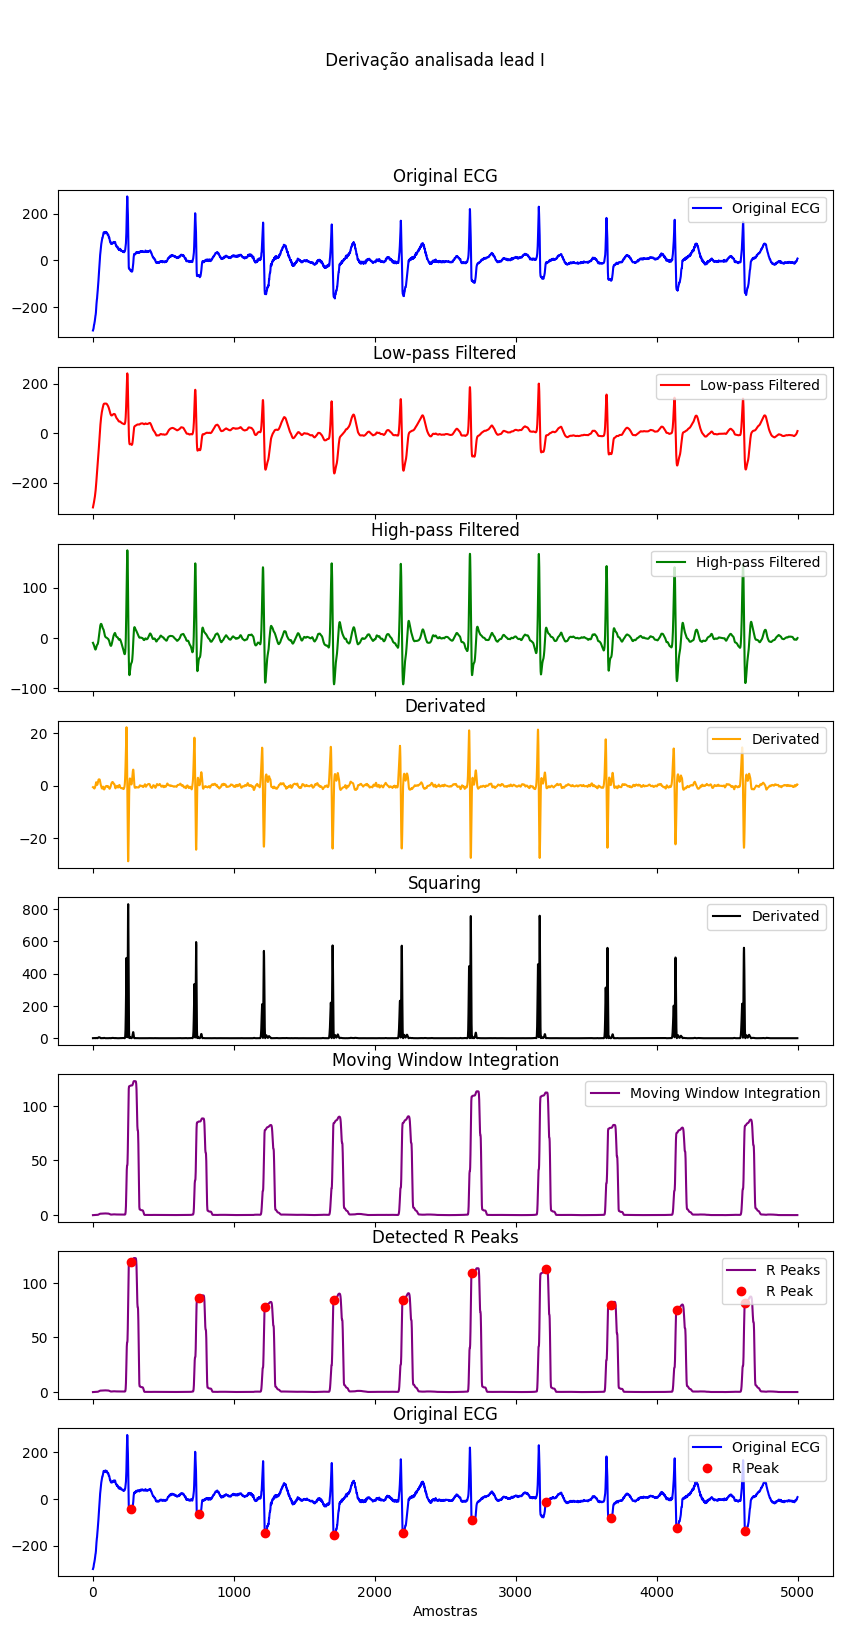

In [33]:
figure, axes = plt.subplots(8, 1, sharex=True, figsize=(10, 18))

axes[0].plot(derivation, color="blue", label='Original ECG')
axes[0].set_title('Original ECG')
axes[0].legend(loc='upper right')

axes[1].plot(lowPassResult, color="red", label='Low-pass Filtered')
axes[1].set_title('Low-pass Filtered')
axes[1].legend(loc='upper right')

axes[2].plot(highPassResult, color="green", label='High-pass Filtered')
# axes[2].plot(rPeacks, highPassResult[rPeacks], 'ro', label='R Peak')
axes[2].set_title('High-pass Filtered')
axes[2].legend(loc='upper right')

axes[3].plot(derivateResult, color="orange", label='Derivated')
axes[3].set_title('Derivated')
axes[3].legend(loc='upper right')

axes[4].plot(squaringResult, color="black", label='Derivated')
axes[4].set_title('Squaring')
axes[4].legend(loc='upper right')

axes[5].plot(integrationResult, color = "purple", label='Moving Window Integration')
axes[5].set_title('Moving Window Integration')
axes[5].legend(loc='upper right')

axes[6].plot(integrationResult, color = "purple", label='R Peaks')
axes[6].plot(rPeacks, integrationResult[rPeacks], 'ro', label='R Peak')
axes[6].set_title('Detected R Peaks')
axes[6].legend(loc='upper right')

axes[7].plot(derivation, color="blue", label='Original ECG')
axes[7].plot(rPeacks, derivation[rPeacks], 'ro', label='R Peak')
axes[7].set_title('Original ECG')
axes[7].legend(loc='upper right')

plt.xlabel("Amostras")
plt.suptitle(f"\n\n Derivação analisada { derivationName }")

plt.show()